# Simulation Algorithm 

## 1. Governing Equation

The Primary Model consist of the inviscid Burgers' equation for the mean flow velocity u(x,t) coupled with the turbulence equation for the turbulent energy density E(x,t) & correlation length l(x,t):

$\Large\frac{\partial \bar{u}}{\partial t} + \bar{u} \frac{\partial \bar{u}}{\partial x} = 0$  (1D Inviscid Burgers' equation)

$\Large\frac{\partial E}{\partial t} + \bar{u} \frac{\partial E}{\partial x} = S_{E} - D_{E}$  (Energy Transport)

$\Large\frac{\partial l}{\partial t} + \bar{u} \frac{\partial l}{\partial x} = S_{l} - D_{l}$  (Correlation length evolution)

Here $S_{E}$ , $D_{E}$ and $S_{l}$ , $D_{l}$ are source & decay terms modelling amplification and dissipation of turbulence.

## 2. Shock capturing: Numerical discretization

- Spatial discretization:- Domain is divided into discrete points $x_{i}$ with spacing $\Delta x$.
- Temporal discretization:- Time progresses in steps of size $\Delta t$.
- Discrete evolution of u employs a Godunov-type scheme or high-resolution finite volume scheme:-

$\Large (u_{i})^{\,n+1} = u_{i}^{\,n} - \frac{\Delta t}{\Delta x} \left( F_{i+\frac{1}{2}}^{\,n} - F_{i-\frac{1}{2}}^{\,n} \right)$

where $F_{i+\frac{1}{2}}^{\,n}$ is the numerical flux computed by solving Riemann problem between cell i and i+1

## 3. Jump condition at shock

The shock position $ x_{s}(t)$ is not fixed but moves according to :-

$ \Large S_{shock} = \frac{1}{2} \left (\bar{u}_{2}^2 - \bar{u}_{1}^2 \right)$

Here $\bar{u}_{1}^2$ & $\bar{u}_{2}^2$ are upstream and downstream velocity respectively.

The turbulence affects shock speedthrough higher moments: ($E_{2}-E_{1}$), ($l_{2}-l_{1}$)

Jump conditions for turbulent energy are quadratic relations:-

$\Large \alpha (E_{2}-E_{1}) + \beta (E_{2}-E_{1})^2 + \gamma = 0 $

where $\alpha$, $\beta$, $\gamma$ depend on mean velocities & correlation lengths, solved numerically at each time step.

## 4. Turbulent energy amplification & decay

- Amplification at shock by jump conditions:-

  $\Large E_{2} = E_{1} (1+A)$  where A is functions of $\bar{u_{1}}$, $\bar{u_{2}}$, $\bar{l_{1}}$, $\bar{l_{1}}$

- Downstream decay follows a nonlinear power law from turbulence theory:

  $\Large E(t) = E_{o} \left (\frac{t}{t_{o}} \right)^(\,-\frac{2}{3})$


This replaces simple exponential decay & requires explicit time tracking on modelling via terms in PDE:

$\Large D_{E} = (C_{d}  E^{\frac{2}{3}})/l$  where $C_{d}$ is decay constant.

# Import libraries & initialize quantities 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import roots

# Spatial and temporal parameters
nx = 200
L = 10.0
dx = L / nx
x = np.linspace(0, L, nx)
dt = 0.002
nt = 1200

# Initial velocity field u(mean flow)
u = np.ones(nx)
u[:nx//2] = 2.0 # Upstream velocity
u += 0.05 * np.sin(2 * np.pi * x / L) # Small upstream perturbations

# Initial turbulent quantities: energy E & correlation length l
E = 0.01 * np.ones(nx)
l = 0.1 * np.ones(nx)

# Constants for turbulence decay
C_d = 0.15

# Numerical Implementation

Now, before implementing, we first have to understand how to compute numerical flux by solving the Riemann problem between cell i & i + 1.

Riemann Problem:- It consist of a conservation law with piecewise constant initial states seperated by a discontinuity at a point (say x=0):

$\Large u(x, 0) =
  \begin{cases}
  u_{L}, &x < 0, \\
  u_{R}, &x > 0
  \end{cases}$

Steps:-
1. Define initial left($ u_{L}$) & right($ u_{R}$) states.
2. Compute wave speeds & structure:

   For a scalar conservation law like Burgers' equation,

   $\Large \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = 0$
   
   the characteristic speed is simplify u itself.
   - If $u_{L}$ > $u_{R}$, a shock forms
   - If $u_{L}$ < $u_{R}$, a rarefraction wave forms
3. Determine intermediate state u*.

   For Burgers' equation, the solution takes the form:-
   - Shock speed(S) = $\Large \frac{1}{2} (u_{L} + u_{R})$
   - For shock: solution u* between $u_{L}$ & $u_{R}$
   - For rarefraction: few of characteristics connecting $u_{L}$ & $u_{R}$.
4. Compute numerical flux across the interface:-

  The Godunov flux is-

  $\Large F(u_{L}, u_{R}) = 
           \begin{cases}
           min_{u \epsilon [u_{L}, u_{R}]} f(u), &u_{L} < u_{R}, \\
           max_{u \epsilon [u_{L}, u_{R}]} f(u), &u_{L} > u_{R}
           \end{cases}$

  For Burgers' equation, flux f(u) = $u^2$/2

5. Use flux to update solution.  

In [3]:
# Numerical flux for Burgers' equation(Godunov flux)
def burgers_flux(u_L, u_R):
    fL = 0.5 * u_L**2
    fR = 0.5 * u_R**2
    if u_L <= u_R:
        return min(fL, fR)
    else:
        return max(fL, fR)

# Godunov scheme solver for 1D inviscid Burgers equation 
def update_velocity(u, dx, dt):
    flux = np.zeros(len(u)+1)
    for i in range(1, len(u)):
        flux[i] = burgers_flux(u[i-1], u[i])
        u_new = np.copy(u)
    for i in range(1, len(u)-1):
        u_new[i] = u[i] - dt/dx * (flux[i+1] - flux[i])
        # Boundary condition
        u_new[0] = u[0]
        u_new[-1] = u[-1]
        return u_new

# Numerical solution of the quadratic jump condition for turbulent energy
# a*E^2 + b*E + c = 0
def solve_jump_energy(E_upstream, u1, u2, l1, l2):
    a = 1.0                                 
    b = -1.5
    c = 0.5 * E_upstream
    roots_val = roots([a, b, c])
    real_roots = roots_val[np.isreal(roots_val)].real
    pos_roots = [r for r in real_roots if r>0]
    if len(pos_roots) == 0:
        return E_upstream
    return pos_roots[0]  

# Apply jump condition at shock
def apply_jump_conditions(u, E, l):
    shock_idx = np.argmax(np.abs(np.diff(u)))
    u1 = u[shock_idx]
    u2 = u[shock_idx+1]
    E1 = E[shock_idx]
    l1 = l[shock_idx]
    l2 = l[shock_idx+1]
    E2 = solve_jump_energy(E1, u1, u2, l1, l2)

    # Amplify turbulent energy downstream of the shock
    E[shock_idx+1:] = E2
    return E, l, shock_idx

# Turbulent energy decay downstream using a nonlinear model
def turbulence_decay(E, l, dt):
    decay_term = C_d * E**(-3/2) / l
    E_new = E - decay_term * dt
    E_new = np.maximum(E_new, 1e-6) # Prevent negative energy
    return E_new

# Time marching loop
shock_pos_track = []
for n in range(nt):
    u = update_velocity(u, dx, dt)
    E, l, shock_idx = apply_jump_conditions(u, E, l)
    E[shock_idx+1:] = turbulence_decay(E[shock_idx+1:], l[shock_idx+1:], dt)
    shock_pos_track.append(shock_idx * dx)    

# Plotting

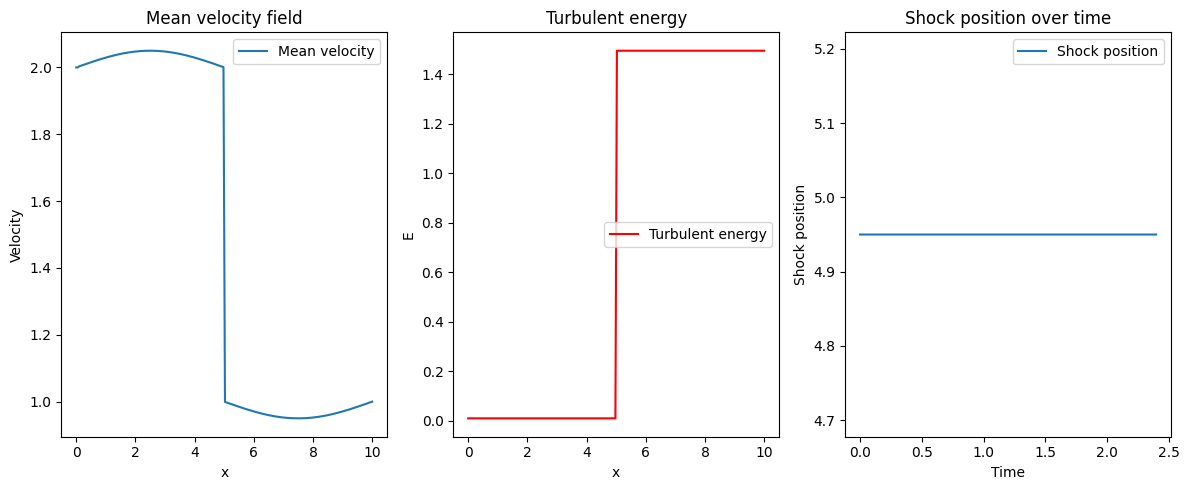

In [4]:
plt.figure(figsize = (12, 5))
plt.subplot(1,3,1)
plt.plot(x, u, label='Mean velocity')
plt.xlabel('x')
plt.ylabel('Velocity')
plt.title('Mean velocity field')
plt.legend()
plt.savefig("Mean velocity field.png", dpi=300)

plt.subplot(1,3,2)
plt.plot(x, E, label='Turbulent energy', color='r')
plt.xlabel('x')
plt.ylabel('E')
plt.title('Turbulent energy')
plt.legend()
plt.savefig("Turbulent energy.png", dpi=300)

plt.subplot(1,3,3)
plt.plot(np.arange(nt) * dt, shock_pos_track, label='Shock position')
plt.xlabel('Time')
plt.ylabel('Shock position')
plt.title('Shock position over time')
plt.legend()
plt.savefig("Shock position over time.png", dpi=300)

plt.tight_layout()
plt.show()

### Interpretation of plot results
MEAN VELOCITY FIELD:
- There is a sharp drop at a particular position, characteristic of a shock, with the velocity transitioning from a higher value (upstream) to a lower value (downstream).
- Smooth variations on either side suggest turbulence, but the main feature is the velocity discontinuity at the shock location.

TURBULENT ENERGY:
- There is an abrupt step, with turbulent energy rising sharply past the shock, indicating that turbulence is being amplified or generated downstream of the shock.
- Upstream (before the shock), turbulent energy is nearly constant and low.

SHOCK POSITION OVER TIME:
- The shock position remains nearly constant, indicating a steady or stationary shock during the sampled time window.

These results are typical when a stationary shock interacts with upstream turbulence in an inviscid or weakly viscous model: the shock amplifies turbulence, creates a sharp velocity jump, and remains at a fixed spatial location throughout the simulation interval. 


# Analysis